# User-Based Collaborative Filtering Recommender System

[Yahoo! Music User Ratings of Musical Artists, version 1.0 (423 MB)](http://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=1)
    This dataset represents a snapshot of the Yahoo! Music community's preferences for various musical artists. The dataset contains over ten million ratings of musical artists given by Yahoo! Music users over the course of a one month period sometime prior to March 2004. Users are represented as meaningless anonymous numbers so that no identifying information is revealed. The dataset may be used by researchers to validate recommender systems or collaborative filtering algorithms. The dataset may serve as a testbed for matrix and graph algorithms including PCA and clustering algorithms. The size of this dataset is 423 MB.

From the readme.txt:
```
This dataset consists of two files:
1. ydata-ymusic-user-artist-ratings-v1_0.txt
2. ydata-ymusic-artist-names-v1_0.txt

The content of the two files are as follows:

=====================================================================

(1) "ydata-ymusic-user-artist-ratings-v1_0.txt" contains user ratings
    of music artists. It contains 11,557,943 ratings of 98,211 artists
    by 1,948,882 anonymous users. The format of each line of the file
    is: anonymous_user_id (TAB) artist_id (TAB) rating. The ratings
    are integers ranging from 0 to 100, except 255 (a special case
    that means "never play again").

Snippet:
1       1000125 90
1       1006373 100
1       1006978 90
1       1007035 100
1       1007098 100

====================================================================

(2) "ydata-ymusic-artist-names-v1_0.txt" contains the artist_id and
    name of each musical artist.

Snippet:
-100    Not Applicable
-99     Unknown Artist
1000001 Bobby "O"
1000002 Jimmy "Z"
1000003 '68 Comeback
```



In [1]:
import re
import timeit
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import pandas.io.sql as psql
import matplotlib.pylab as plt
from collections import defaultdict

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Query the database
The steps used to create and import data into the database are in the scripts/initialize_db.sh file of this repository. 

They are:
* Create the ymusic_data database with the createdb command
* Create 3 tables and define the schema
* Remove the first two lines of the artist-names file
* Import the data files into the respective psql tables.

I connect with the database using `psycopg2` and query with `pandas.io.sql` (as `psql`) 

NOTE: The avg_rating in ym_artist and ym_user tables is deceptive because 255 means never play again, so it should probably be 0 for the range to make much sense. A very disliked artist could have an avg_rating greater than 100.

In [2]:
conn = psycopg2.connect("dbname=ymusic_data user=btq")
# Open a cursor to perform database operations
cur = conn.cursor()
# Query the database and obtain data as Python objects
cur.execute("SELECT * FROM ym_ratings WHERE uid <= 3 and uid > 1;")
cur.fetchall()

[(2, 1004623, 0),
 (2, 1018143, 0),
 (2, 1040071, 90),
 (2, 1053438, 90),
 (2, 1098087, 90),
 (2, 1098636, 90),
 (3, 1006316, 90)]

Great! We can successfully query the db. lets get a sense of what the data look like. With the connection to the database established with psycopg2, I can use Pandas SQL functions to pull data into a dataframe.

### Number of ratings for users
I want to get a sense of what the numbers look like. Specifically, are there users with sufficient number of ratings from which to make recommendations?

In [3]:
qu_string = "SELECT uid, num_ratings FROM ym_user;"
all_user_df = psql.read_sql(qu_string, conn)
all_user_df.head(5)

uid  num_ratings
0    1           40
1    2            6
2    3            1
3    4           37
4    5           72

In [4]:
print all_user_df.info()
all_user_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1948882 entries, 0 to 1948881
Data columns (total 2 columns):
uid            int64
num_ratings    int64
dtypes: int64(2)
memory usage: 44.6 MB
None


uid     num_ratings
count  1948882.000000  1948882.000000
mean    974441.500000       59.305510
std     562593.917997      164.149996
min          1.000000        1.000000
25%     487221.250000        6.000000
50%     974441.500000       24.000000
75%    1461661.750000       62.000000
max    1948882.000000    97993.000000

1     197982
2      90045
3      65106
4      55777
5      46411
6      41710
7      38205
8      36514
9      34200
10     32161
Name: num_ratings, dtype: int64
Total number of ratings: 1948882


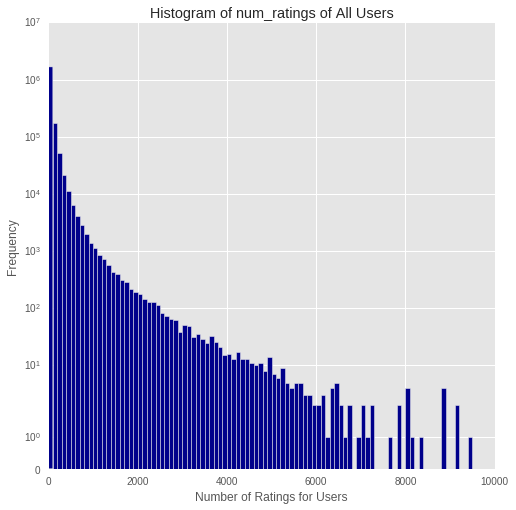

In [5]:
print all_user_df['num_ratings'].value_counts()[0:10]
print 'Total number of ratings:', all_user_df['num_ratings'].value_counts().sum()
fig,ax = plt.subplots(figsize=(8,8))
ax = all_user_df['num_ratings'].hist(color='DarkBlue',bins=100,range=(1,10000))
ax.set_yscale('symlog')
ax.set_xlim(0,10000)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Ratings for Users')
ax.set_title('Histogram of num_ratings of All Users')
plt.show()

About 10% of the users only rate one artist, and 30% have rated 10 or less. Therefore, 70% have rated more that 10 artists. These users will be better for user-based collaborative filtering, as they have enough preference data from which to make a good prediction from. This is why Netflix always presses you to rate several movies so they have enough data to make a recommendation on.

### Number of ratings for artists
I want to know the same thing for artists. How many times are each of them rated?

In [6]:
qu_string = "SELECT aid, num_ratings FROM ym_artist;"
all_artist_df = psql.read_sql(qu_string, conn)
all_artist_df.head(5)

aid  num_ratings
0  1068731            1
1  1075608            1
2  1069922           10
3  1034534            1
4  1096781            5

In [7]:
all_artist_df.info()
all_artist_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97812 entries, 0 to 97811
Data columns (total 2 columns):
aid            97812 non-null int64
num_ratings    97812 non-null int64
dtypes: int64(2)
memory usage: 2.2 MB


aid    num_ratings
count    97812.000000   97812.000000
mean   1050860.376498    1180.812487
std      29419.824983   13437.416486
min    1000001.000000       1.000000
25%    1025077.750000       1.000000
50%    1051997.500000       3.000000
75%    1076519.250000      10.000000
max    1101114.000000  783871.000000

1     39813
2      7777
3      6435
4      4917
5      3777
6      3143
7      2473
8      2050
9      1691
10     1527
Name: num_ratings, dtype: int64
Total number of ratings: 97812


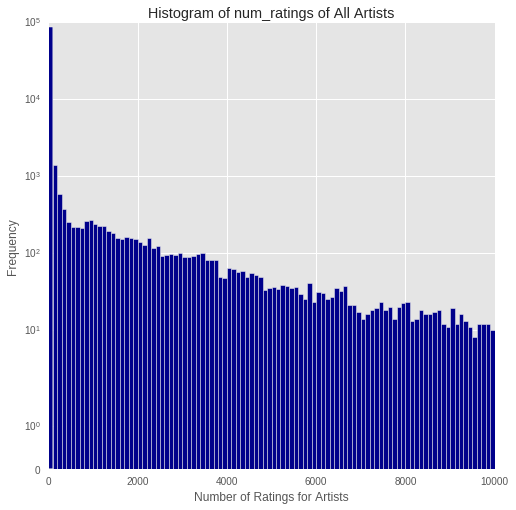

In [8]:
print all_artist_df['num_ratings'].value_counts()[0:10]
print 'Total number of ratings:', all_artist_df['num_ratings'].value_counts().sum()

fig,ax = plt.subplots(figsize=(8,8))
ax = all_artist_df['num_ratings'].hist(color='DarkBlue',bins=100,range=(1,10000))
ax.set_yscale('symlog')
ax.set_xlim(0,10000)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Ratings for Artists')
ax.set_title('Histogram of num_ratings of All Artists')
plt.show()

In [9]:
#clear these dfs
del all_artist_df
del all_user_df

41% of the artists are rated only one time, and 75% of artists are rated 10 times or less. That still leaves more that 20,000 artists with more than 10 ratings. 

### User-based Collaborative Filtering
To determine how similar users are in their tastes, I will be comparing a user with every other user that has rated one of the items. For the first example, to make this more explainable, I will start with a user that has only rated 6 artists.

#### 1.Query the db for all of this user's ratings

In [10]:
UID = 2
qu_string = "SELECT * FROM ym_ratings WHERE uid = %i ;" % UID
user_df = psql.read_sql(qu_string, conn)
user_df

uid      aid  rating
0    2  1004623       0
1    2  1018143       0
2    2  1040071      90
3    2  1053438      90
4    2  1098087      90
5    2  1098636      90

#### 2.Query all the artists our UID has rated.

In [11]:
qa_string = "SELECT * FROM ym_artist WHERE aid = %s" % " OR aid = ".join([str(a) for a in user_df.aid.unique()])
artists_df = psql.read_sql(qa_string,conn)
artists_df

aid            name  num_ratings  avg_rating
0  1040071         Ja Rule       337804     68.6612
1  1018143  Mint Condition        33387     50.2580
2  1004623            Case        29761     60.4288
3  1098087         Ashanti         2689     89.5288
4  1098636            Baby        35649     66.8373
5  1053438           Musiq       109104     63.0521

This gives me an idea for the amount of data I will be pulling. It will be at least 337,804 ratings.

#### 3.Query the rest of the data. This can return a very large data set. Be careful.

In [12]:
qstring = 'SELECT uid, aid, rating FROM ym_ratings WHERE aid IN (SELECT aid FROM ym_ratings WHERE uid = %i) ;' % UID
tic=timeit.default_timer()
data_df = psql.read_sql(qstring, conn)
toc=timeit.default_timer()
print 'Time for query: ', toc-tic
print 'Shape of data: ', data_df.shape
print data_df.info()
data_df.head()

Time for query:  62.6603560448
Shape of data:  (548394, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 548394 entries, 0 to 548393
Data columns (total 3 columns):
uid       548394 non-null int64
aid       548394 non-null int64
rating    548394 non-null int64
dtypes: int64(3)
memory usage: 16.7 MB
None


uid      aid  rating
0    2  1004623       0
1    2  1018143       0
2    2  1040071      90
3    2  1053438      90
4    2  1098087      90

It took about a minute to get the data, but it's here. Now I will re-assign 0's to 10 and 255 to 0. In the rating system, 255 mean never play again, so we'll make that absolute zero. Seeing as a 0 rating is not as extreme as rating it to never be played again, I recode the 0 ratings to 10. It would also make sense to simply equate a 255 rating as a 0, because there probably isn't much difference pragmatically.

In [13]:
#convert 0s to 10 (becuase we're pushing 255 to 0)
data_df.loc[data_df['rating']==0,'rating']=10
#convert 255 to 0
data_df.loc[data_df['rating']==255,'rating']=0

In [14]:
#Create a lookup-like dict for artist names
aid_lookup = pd.Series(artists_df['name'].values,index=artists_df['aid']).to_dict()

#Pivot data frame to be indexed by uid and the columns with be the artists
pivoted_df = pd.pivot_table(data_df,values='rating',columns=['aid'],index=['uid'],fill_value=None)
pivoted_df.rename(columns=aid_lookup,inplace=True)
pivoted_df.head(5)

aid  Case  Mint Condition  Ja Rule  Musiq  Ashanti  Baby
uid                                                     
2      10              10       90     90       90    90
10    NaN             NaN       50    NaN      NaN   NaN
20    NaN             NaN       80     70      NaN   NaN
21    NaN             NaN       90    NaN      NaN   NaN
28    NaN             NaN      100    100      NaN   100

In [15]:
pivoted_df.describe()

aid            Case  Mint Condition        Ja Rule          Musiq  \
count  29761.000000    33387.000000  337804.000000  109104.000000   
mean      62.210141       52.971636      69.781953      64.744427   
std       36.591502       37.234335      34.004977      35.885274   
min        0.000000        0.000000       0.000000       0.000000   
25%       10.000000       10.000000      50.000000      30.000000   
50%       79.000000       50.000000      90.000000      83.000000   
75%      100.000000       90.000000      90.000000      98.000000   
max      100.000000      100.000000     100.000000     100.000000   

aid        Ashanti          Baby  
count  2689.000000  35649.000000  
mean     89.614355     68.373980  
std      11.418987     36.540526  
min       1.000000      0.000000  
25%      90.000000     30.000000  
50%      90.000000     90.000000  
75%      90.000000    100.000000  
max     100.000000    100.000000

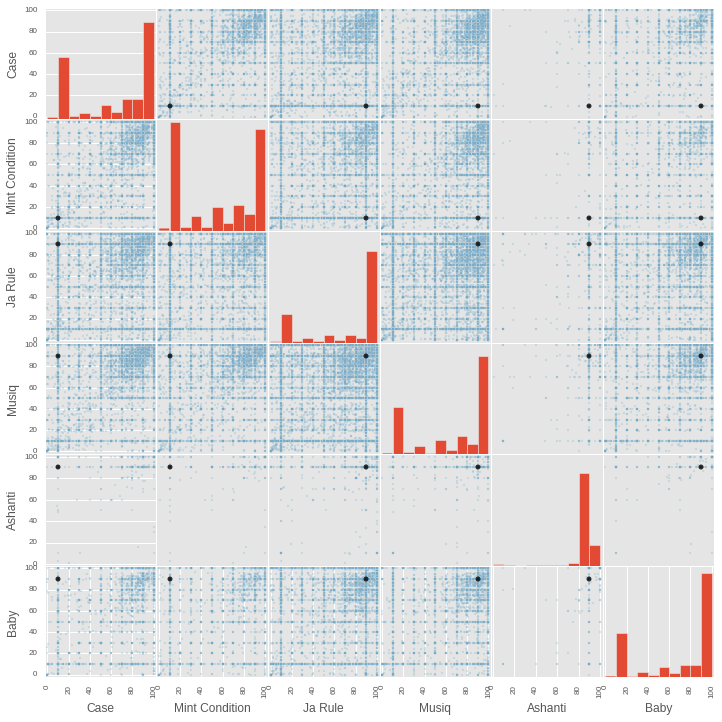

In [16]:
from lib import btq_pandas_plotting as btq
btq.scatter_matrix_and1(pivoted_df, alpha=0.2, figsize=(12,12), rowname=UID);
plt.savefig('img/Scatter_matrix_and1.png',dpi=300)
plt.show()

UID 2 is the black dot in the scatter matrix above, all other ratings are in blue, with histograms in red along the diagonal. It is apparent from the figure above that UID 2 is with the majority except for ratings for Case and Mint Condition. Next, similarity scores will be computed using euclidean distance and Pearson correlation.

In [17]:
#Extract the UID row from the pivoted data
uid_row_df = pivoted_df.loc[UID]
pivoted_df = pivoted_df[pivoted_df.index != UID]
uid_row_df.head()

aid
Case              10
Mint Condition    10
Ja Rule           90
Musiq             90
Ashanti           90
Name: 2, dtype: float64

### Similarity metrics
#### Euclidean distance
Briefly, the straight line distance between two points. The formula is:
$d = \sqrt{\displaystyle\sum_{i=1}^{artists}\left(x_i - y_i\right)^2}$

To convert this to a similarity score, $d = \frac{1}{d+1}$ Two users who rate every artist the same would have a value of 1. Computed in one line with pandas:

` pivoted_df.dropna().rsub(uid_row_df).pow(2).sum(axis=1).pow(.5).add(1).rdiv(1) `

#### Pearson correlation coefficient
$r = \frac{n\sum x_iy_i-\sum x_i\sum y_i}{\sqrt{n\sum x_i^2-(\sum x_i)^2}~\sqrt{n\sum y_i^2-(\sum y_i)^2}}, where \sum = \sum_{i=1}^{artists}$

The correlation coefficient is scale independent, so it is often a cleaner measure of similarity. Computed in one line in pandas:

` pivoted_df.dropna().corrwith(uid_row_df,axis=1) `

#### Making recommendations

$R(aid) = \frac{\displaystyle\sum_{u=1}^{users}(rating_u(aid) * similarity_u)}{\displaystyle\sum_{u=1}^{users}similarity_u}$

To make a recommendation, the user's rating for an artist is multiplied by the similarity metric of that user. That is done for all recommending users, and then summed. that value is then normalized by the sum of similarity metrics. If a user does not have a rating for that aid, then it is not included in the numerator or denominator. 

Below, I will test to see how well predictions match the actual rating for each of the artists (using leave one out). I use both metrics so we have a comparison.

In [18]:
num = 5 #number of the top similar users to use for predictions
column_list = pivoted_df.columns

for col in pivoted_df.columns:
    print '\n',col
    keep_cols = column_list.drop(col)
    #create a test set that contains the column to test
    test_col_df = pivoted_df[col].dropna()
    #create a train dataframe that does not contain the test column
    train_df = pivoted_df.loc[test_col_df.index,keep_cols]
    print train_df.shape
    uid_test_col = uid_row_df[col]
    #euclid. dist from uid. then normalized through inversion to yield a similarity value
    dist_s = train_df.dropna().rsub(uid_row_df).pow(2).sum(axis=1).pow(.5).add(1).rdiv(1).sort_values(ascending=False)[0:num]
    #name the series so we have a column label later
    dist_s.name = 'dist_sim'
    #print dist_s
    #pearson correlation
    corr_s = train_df.dropna().corrwith(uid_row_df,axis=1).sort_values(ascending=False)[0:num]
    #name the series so we have a column label later
    corr_s.name = 'corr_sim'
    #print corr_s
    
    # concatenate correlations with the rating values for this column
    corr_df = pd.concat([test_col_df.loc[corr_s.index], corr_s],axis=1)
    # multiply each rating by similarity metric
    corr_df = corr_df.assign(csx = corr_df[col]*corr_df['corr_sim'])
    # normalize sum of products by the sum of similarity to normalize
    corr_pred = corr_df['csx'].sum() / corr_df['corr_sim'].sum()
    print 'Pearson corr. prediction= ', corr_pred
    
    # concatenate distances with the rating values for this column
    dist_df = pd.concat([test_col_df.loc[dist_s.index], dist_s],axis=1)
    # multiply each rating by similarity metric
    dist_df = dist_df.assign(csx = dist_df[col]*dist_df['dist_sim'])
    # normalize sum of products by the sum of similarity to normalize
    dist_pred = dist_df['csx'].sum() / dist_df['dist_sim'].sum()
    print 'Euclidean dist. prediction= ', dist_pred
    
    print 'Actual= ', uid_test_col


Case
(29760, 5)
Pearson corr. prediction=  58.1745159472
Euclidean dist. prediction=  50.4224953442
Actual=  10.0

Mint Condition
(33386, 5)
Pearson corr. prediction=  82.2323557971
Euclidean dist. prediction=  35.2009482538
Actual=  10.0

Ja Rule
(337803, 5)
Pearson corr. prediction=  78.7198717274
Euclidean dist. prediction=  69.7630477326
Actual=  90.0

Musiq
(109103, 5)
Pearson corr. prediction=  65.4158308251
Euclidean dist. prediction=  59.2105571198
Actual=  90.0

Ashanti
(2688, 5)
Pearson corr. prediction=  92.0592327549
Euclidean dist. prediction=  94.1420253827
Actual=  90.0

Baby
(35648, 5)
Pearson corr. prediction=  74.7564363147
Euclidean dist. prediction=  54.7214424553
Actual=  90.0


#### Need more samples

Some of the predictions are close, others are off by as much as 72! Sometimes the distance metric provides the more accurate prediction, other times the correlation metric does. As the number of ratings increases, we should get better preditions. I will drop all users that have not rated all 6 artists.

In [19]:
all_ratings_complete_df = pivoted_df.dropna()
print all_ratings_complete_df.shape
all_ratings_complete_df.head(5)

(81, 6)


aid     Case  Mint Condition  Ja Rule  Musiq  Ashanti  Baby
uid                                                        
45546     80              10       80     10      100    10
89601     90              90       90    100       90    70
99795     10              10       10     20       70    20
102565   100              10       90    100       90   100
128685   100             100       90    100      100    90

Down to 81 users who have rated all 6 artists. The top 5 for each metric will be my recommenders for UID 2. There may be some overlap in the two top 5s, so I am not guaranteed to have 10 recommenders.

In [20]:
#num is the top num of similarity values to use. 5 is the top 5 (for both corr. and dist.)
num=5
#euclid. dist from uid. then normalized through inversion to yield a similarity value
all_dist_s = all_ratings_complete_df.dropna().rsub(uid_row_df).pow(2).sum(axis=1).pow(.5).add(1).rdiv(1) #.sort_values(ascending=False)[0:num]
all_dist_s.name = 'dist_sim'
dist_s = all_dist_s.sort_values(ascending=False)[0:num]
print dist_s 
#pearson correlation
all_corr_s = all_ratings_complete_df.dropna().corrwith(uid_row_df,axis=1) #.sort_values(ascending=False)[0:num]
all_corr_s.name = 'corr_sim'
corr_s = all_corr_s.sort_values(ascending=False)[0:num]
print corr_s

uid
1652817    0.062500
1709192    0.054584
1728147    0.018882
1937099    0.016861
427575     0.014688
Name: dist_sim, dtype: float64
uid
1652817    0.990256
1709192    0.985184
1937099    0.956183
1655700    0.918559
654010     0.918025
Name: corr_sim, dtype: float64


In [21]:
#Unique list of most similar uids
most_sim = dist_s.append(corr_s).index.unique()
print most_sim

[1652817 1709192 1728147 1937099  427575 1655700  654010]


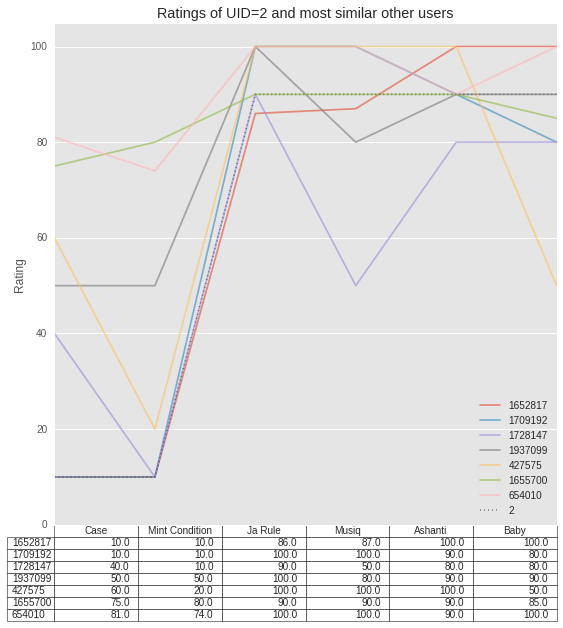

In [22]:
fig,ax = plt.subplots(figsize=(9,9))
ax.get_xaxis().set_visible(False)
#uid_row_df.plot(ax=ax)
#ax.hold(True)
all_ratings_complete_df.loc[most_sim].T.plot(ax=ax,alpha=0.6,table=all_ratings_complete_df.loc[most_sim])
ax.hold(True)
uid_row_df.plot(ax=ax,color='k',linestyle=':',label=UID,alpha=0.4)
ax.set_ylim(0,105)
ax.set_ylabel('Rating')
ax.set_xlabel('Artist')
ax.set_title('Ratings of UID=%i and most similar other users' % UID)
plt.legend(loc='best')
plt.savefig('img/SimilarUsersRatingsUID%i.png'%UID,dpi=300)
plt.show()

The plot nicely shows the ratings of the most similar users and UID 2. Notice how Case and Mint Condition, the 2 lowest rated artists by UID 2 has a lot of variance even with the most similar users. Ja Rule and Ashanti, on the other hand, are rated favorably by all users in the plot.

#### Pull all the ratings for our most similar users
Next, clear all the other dataframes and pull the data for the most similar users to make recommendations.

In [23]:
#Clear other dfs
del artists_df, data_df, pivoted_df, all_ratings_complete_df
#Query database for all the ratings from the most similar users
qa_string = "SELECT * FROM ym_ratings WHERE uid = %s" % " OR uid = ".join([str(a) for a in most_sim])
tic=timeit.default_timer()
rec_df = psql.read_sql(qa_string, conn)
toc=timeit.default_timer()
print 'Time for query: ', toc-tic
print 'Shape of data: ', rec_df.shape
rec_df.head()

Time for query:  0.011449098587
Shape of data:  (3417, 3)


uid      aid  rating
0  427575  1000026      50
1  427575  1000084       0
2  427575  1000125      50
3  427575  1000152      10
4  427575  1000193       0

In [25]:
#Create a lookup-like dict for artist names
qu_string = "SELECT aid, name FROM ym_artist;"
all_artist_df = psql.read_sql(qu_string, conn)
aid_lookup = pd.Series(all_artist_df['name'].values,index=all_artist_df['aid']).to_dict()

#Pivot data so rows are uids and columns are artists
rec_pivot_df = pd.pivot_table(rec_df,values='rating',columns=['aid'],index=['uid'],fill_value=None)
rec_pivot_df.rename(columns=aid_lookup,inplace=True)
print 'Shape of data: ', rec_pivot_df.shape
rec_pivot_df.head(10)

 Shape of data:  (7, 1611)


aid      112  The 2 Live Crew  2Pac  3rd Bass  3T  69 Boyz  702  8Off  \
uid                                                                     
427575    50                0    50        10 NaN        0   80     0   
654010   100              NaN    90       NaN NaN      NaN  NaN   NaN   
1652817  100                0   NaN         0   0        0  NaN   NaN   
1655700   92              NaN    90       NaN NaN      NaN  NaN   NaN   
1709192  100              NaN   NaN       NaN NaN      NaN  NaN   NaN   
1728147   70                1   NaN       NaN NaN       10   50   NaN   
1937099  100              NaN    90       NaN NaN      NaN   90   NaN   

aid      95 South  A Tribe Called Quest  Aaliyah  Paula Abdul ...   Baby Bash  \
uid                                                           ...               
427575          0                    81      100           66 ...         NaN   
654010        NaN                    50       90          NaN ...         NaN   
1652817       NaN                   NaN      100            0 ...         NaN   
1655700       NaN                   NaN       90          NaN ...         NaN   
1709192       NaN                   NaN      100          NaN ...         NaN   
1728147       NaN                    30       70          NaN ...         NaN   
1937099       NaN                   NaN      100          NaN ...          70   

aid      Kevin Lyttle  Cerati/Melero  Now City  Jhene  George Pajon, Jr.  \
uid                                                                        
427575            NaN            NaN       NaN    NaN                NaN   
654010             90            NaN       NaN    NaN                NaN   
1652817           NaN              0         0      0                  0   
1655700           NaN            NaN       NaN    NaN                NaN   
1709192           NaN            NaN       NaN    NaN                NaN   
1728147           NaN            NaN       NaN    NaN                NaN   
1937099           NaN            NaN       NaN    NaN                NaN   

aid      G-Unit  Jae Millz  Van Hunt  Joss Stone  I-20  Jin  
uid                                                          
427575       50        NaN         0           0    70  NaN  
654010       90        NaN       NaN         NaN    90  NaN  
1652817     100        100       NaN         NaN   NaN  NaN  
1655700      78        NaN       NaN         NaN   NaN  NaN  
1709192     NaN        NaN       NaN         NaN   NaN  NaN  
1728147      90         50         0          30    50   70  
1937099      50        NaN       NaN         NaN   NaN  NaN  

[7 rows x 1611 columns]

There are a lot of columns with only one rating. That will skew our measures. For example, if only one user rates an artist 100, then the computed recommendation would be 100. Therefore, I will drop all artist columns that have fewer that 4 ratings.

In [26]:
#Drop columns containing half the rowsize or greater number of NaNs 
rec_pivot_df.dropna(thresh=rec_pivot_df.shape[0]/2+1,axis=1,inplace=True)
#Remove the columns UID has already rated
rec_pivot_df.drop(uid_row_df.index,axis=1,inplace=True)
rec_pivot_df.head(10)

aid      112  2Pac  Aaliyah  Yolanda Adams  Aerosmith  Babyface  \
uid                                                               
427575    50    50      100              0          0         0   
654010   100    90       90            NaN         90       NaN   
1652817  100   NaN      100              0        NaN         0   
1655700   92    90       90             90        NaN        80   
1709192  100   NaN      100            NaN          0         0   
1728147   70   NaN       70             10         10       NaN   
1937099  100    90      100            NaN        NaN        70   

aid      Backstreet Boys  Erykah Badu  Anita Baker  Bell Biv DeVoe  \
uid                                                                  
427575                 0           67            0              20   
654010               100           81          NaN             NaN   
1652817              NaN            0            0               0   
1655700              NaN          100           80             NaN   
1709192                0          NaN          NaN             NaN   
1728147               10           10          NaN              10   
1937099               90           90           50              90   

aid      Eric Benet  Blackstreet   ...    Amerie  Kelly Rowland  \
uid                                ...                            
427575            0           10   ...        60             15   
654010          NaN          100   ...       NaN            100   
1652817           0            0   ...         0            100   
1655700          84           80   ...        89            100   
1709192           0          100   ...        80            NaN   
1728147           5           30   ...        80             50   
1937099          70           90   ...        90             90   

aid      Marques Houston  Wayne Wonder  Pharrell  David Banner  Chingy   JS  \
uid                                                                           
427575                90            40       NaN            70      70   50   
654010               100            90       100           NaN     100  NaN   
1652817              NaN           100       100           100      90    0   
1655700               80           NaN       NaN            75      80  NaN   
1709192              100           NaN       NaN            90     100  100   
1728147              NaN            70        70            60      90  NaN   
1937099               80           100        90           NaN      80   70   

aid      Murphy Lee  Lil Scrappy  Bad Boy's Da Band  G-Unit  
uid                                                          
427575          NaN          NaN                100      50  
654010           90           90                NaN      90  
1652817         100            0                100     100  
1655700         NaN          NaN                NaN      78  
1709192         100          NaN                NaN     NaN  
1728147          80           50                 70      90  
1937099          90           30                 90      50  

[7 rows x 241 columns]

By dropping the excessive NaN columns, the dataframe has gone from 1611 to 241 columns.

#### Recommend New Artists
Finally, I can make recommendations for UID 2 by using the 241 artist ratings from the 7 most similar users.

Recommendations based on correlation
aid
Beyonce         93.345991
Aaliyah         93.110502
Lil' Flip       92.863811
Murphy Lee      92.411505
Tupac Shakur    91.990787
Name: corr_pred, dtype: float64

Recommendations based on distance
aid
Lil' Flip     96.240053
Murphy Lee    96.024107
Aaliyah       95.895756
Next          95.065186
Beyonce       94.979604
Name: dist_pred, dtype: float64


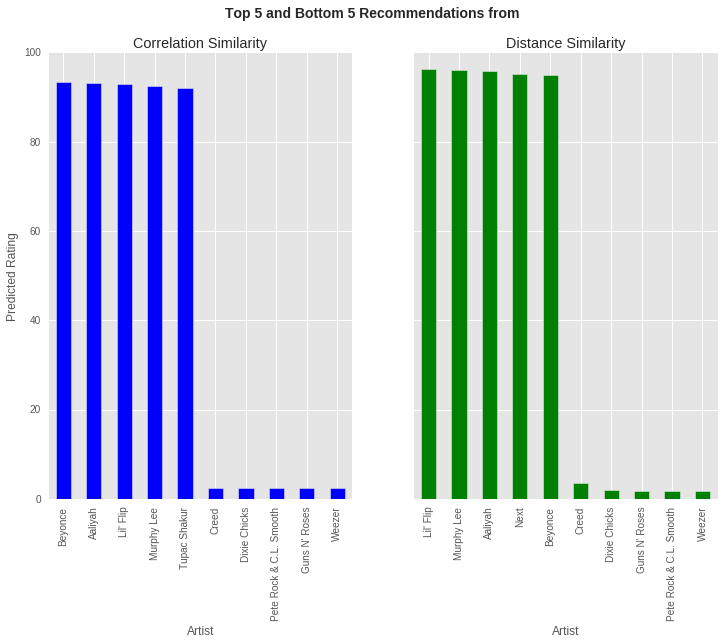

In [27]:
#concatenate the dist and corr similarity metrics for the respective uids (use the index form rec_pivot_df)
corr_sim = all_corr_s.loc[rec_pivot_df.index]
dist_sim = all_dist_s.loc[rec_pivot_df.index]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)

#Calculate correlation-based user recommendation
corr_pred = rec_pivot_df.apply(lambda x: x*corr_sim,axis=0).sum() / rec_pivot_df.apply(lambda x: x.notnull().mul(corr_sim)).sum()
corr_pred.name = 'corr_pred'
print 'Recommendations based on correlation'
print corr_pred.sort_values(ascending=False)[0:5]

#Create a df of top and bottom 5 recommended artists and plot them
corr_pred_plot = corr_pred.sort_values(ascending=False)[0:5].append(corr_pred.sort_values(ascending=False)[-6:-1])
corr_pred_plot.plot(kind='bar',ax=ax1)
ax1.set_title('Correlation Similarity')
ax1.set_xlabel('Artist')
ax1.set_ylabel('Predicted Rating')

#Calculate distance-based user recommendation
dist_pred = rec_pivot_df.apply(lambda x: x*dist_sim,axis=0).sum() / rec_pivot_df.apply(lambda x: x.notnull().mul(dist_sim)).sum()
dist_pred.name = 'dist_pred'
print '\nRecommendations based on distance'
print dist_pred.sort_values(ascending=False)[0:5]

#Create a df of top and bottom 5 recommended artists and plot them
dist_pred_plot = dist_pred.sort_values(ascending=False)[0:5].append(dist_pred.sort_values(ascending=False)[-6:-1])
dist_pred_plot.plot(kind='bar',color='g',ax=ax2)
ax2.set_title('Distance Similarity')
ax2.set_xlabel('Artist')
ax2.set_ylabel('Predicted Rating')
fig.suptitle('Top 5 and Bottom 5 Recommendations from',fontsize=14,fontweight='bold')
plt.show()

#### Weezer is the anti-Beyonce. Oh, and no one likes Creed.
The correlation and distance based similarity metrics produced very similar top and bottom 5s, with 9 of 10 artists present in both. Weezer is the bottom of both recommendations, indicating that other users who rated like UID 2 would probably not like Weezer. Aaliyah, Beyonce, Lil' Flip, and Murphy Lee are the highest recommendations for UID 2.

This concludes this notebook's exploration of user-based collaborative filtering for recommendations. Coming soon, I will demonstrate item-based collaborative filtering with the same dataset.